In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output


# Any results you write to the current directory are saved as output.

import numpy as np
import gzip
import os
from os.path import basename
import glob
import time
#import cv2
import pandas as pd
import random
from PIL import Image
#import scipy.ndimage
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imresize
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
#from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras import backend as K
from keras.models import model_from_json

import matplotlib.pyplot as plt

K.set_image_dim_ordering('th') # Theano dimension ordering in this code

Using TensorFlow backend.


In [2]:
# todo: use opencv2 to read images


In [3]:
INPUT_PATH = ''
dims = [128, 128] 
img_rows = dims[0]
img_cols = dims[1]
n_batch = 32
original_dim = [1,1] # will be set later

train = sorted(glob.glob('train/*.jpg'))
masks = sorted(glob.glob('train_masks/*.gif'))
test  = sorted(glob.glob('test/*.jpg'))
print('Number of training images: ', len(train), ' Number of corresponding masks: ', len(masks), ' Number of test images: ', len(test))

meta = pd.read_csv('metadata.csv')
mask_df = pd.read_csv('train_masks_csv/train_masks.csv')
ids_train = mask_df['img'].map(lambda s: s.split('_')[0]).unique()
print('Length of ids_train ', len(ids_train))

Number of training images:  5088  Number of corresponding masks:  0  Number of test images:  100064
Length of ids_train  318


In [4]:
mask_df.head()
#'''rle_mask is the run-length encoded version of the training set masks the input for the encoder has to be binary; zeroes and ones.
#I read the encoding output as the pixel number of the first 1 (in the flattened mask) followed by the count of consecutive (uninterupted) series of pixels with value 
#'''

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


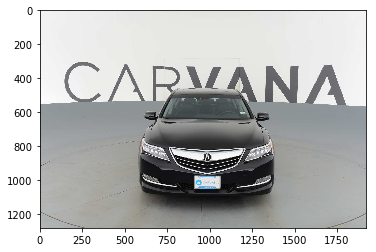

(1918, 1280)


In [5]:
image = Image.open('train/00087a6bd4dc_01.jpg')
plt.imshow(image)
plt.show()
print(image.size)
original_dim = image.size

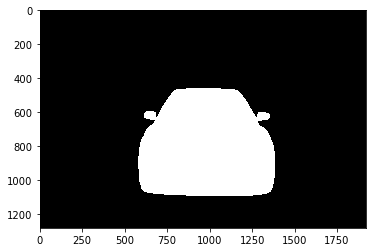

In [6]:
img = Image.open('train_masks_pics/00087a6bd4dc_01_mask.gif').convert('RGB')
plt.imshow(img)
plt.show()

In [7]:
# from ecobill:

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
# this is the U-Net model I encountered in the LUNA16 Challenge
def get_unet():
    inputs = Input((3,img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)    
    conv1 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation='relu')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    #      Concatenate(axis=3)([residual, upconv])
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation='relu')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation='relu')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation='relu')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation='relu')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)   #9

    model = Model(inputs=inputs, outputs=conv10)
    #      `Model(inputs=/input_19, outputs=sigmoid.0)`

    #model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])  #LUNA16
    model.compile(optimizer=Adam(5e-4), loss='binary_crossentropy', metrics=[dice_coef]) #ecobill

    return model

In [9]:
# split the train set into train and validation:
train_images, validation_images = train_test_split(train, train_size=0.8, test_size=0.2)
print('Split into training set with ', len(train_images), ' images and validation set with  ', len(validation_images), ' images')

Split into training set with  4070  images and validation set with   1018  images


In [10]:
#use loading functions from: ecobill

# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, masks, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        
        Image.resize(size, resample=0)

        Returns a resized copy of this image.
        Parameters:	

        size – The requested size in pixels, as a 2-tuple: (width, height).
        resample – An optional resampling filter. This can be one of PIL.Image.NEAREST, 
        PIL.Image.BOX, PIL.Image.BILINEAR, PIL.Image.HAMMING, PIL.Image.BICUBIC or PIL.Image.LANCZOS. 
        If omitted, or if the image has mode “1” or “P”, it is set PIL.Image.NEAREST
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = Image.open(images[i])
                #original_img = cv2.imread(images[i]) # todo cv2 here
                resized_img = imresize(original_img, dims+[3]) #this looks like TensorFlow ordering 
                array_img = resized_img / 255   
                array_img = array_img.swapaxes(0,2)
                imgs.append(array_img)
                #imgs is a numpy array with dim: (batch size X 128 X 128 X 3)
                
                # masks
                mask_filename = basename(images[i])
                no_extension = os.path.splitext(mask_filename)[0]
                correct_mask = INPUT_PATH + 'train_masks_pics/' + no_extension + '_mask.gif' 
                original_mask = Image.open(correct_mask).convert('L')
                data = np.asarray( original_mask, dtype="int32" )
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = resized_mask / 255
                labels.append(array_mask)
            imgs = np.array(imgs)
            labels = np.array(labels)
            relabel = labels.reshape(-1, dims[0], dims[1], 1)
            yield imgs, relabel.swapaxes(1, 3)

Size of batch:  32
shape of img  (32, 3, 128, 128) number dimensions:  3
shape of msk  (32, 1, 128, 128) number dimensions:  3


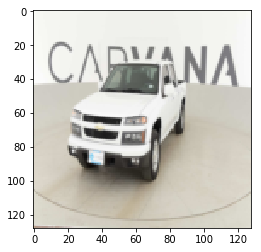

resized up:  (1280, 1918, 3)
resized swapaxes:  (1918, 1280, 3)
resized swapaxes shape[-1]:  3


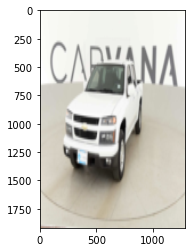

(32, 128, 128, 1)


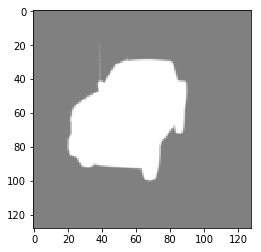

In [11]:
train_gen = data_gen_small('train/', masks, train_images, n_batch, dims) 
img, msk = next(train_gen)
print('Size of batch: ', len(img))
print('shape of img ', img.shape, 'number dimensions: ', img[0].ndim)
print('shape of msk ', msk.shape, 'number dimensions: ', msk[0].ndim)
newshape = img[0].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

#try resize up 

resized_img = imresize(img[0], [1280, 1918]+[3])
print('resized up: ', resized_img.shape)
newshape = resized_img.swapaxes(0,1)
print('resized swapaxes: ', newshape.shape)
print('resized swapaxes shape[-1]: ', newshape.shape[-1])

plt.imshow(newshape)
plt.show()

newshape = msk.swapaxes(1,3)
print(newshape.shape)
plt.imshow(grey2rgb(newshape[0]), alpha=0.5)
plt.show()

In [12]:
# create an instance of a validation generator:
validation_gen = data_gen_small('train/', masks, validation_images, n_batch, dims) 

In [13]:
# define and compile the model
model = get_unet()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 128, 128)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 128, 128)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 128, 128)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 64, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [48]:
# fit the model and check dice_coef on validation data at end of each epoch
model.fit_generator(train_gen, steps_per_epoch=100, epochs=10, validation_data=validation_gen, validation_steps=50)


# serialize model to JSON
model_json = model.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_2.h5")
print("Saved model to disk")


Epoch 1/10
100/100 [==============================] - 35s - loss: 0.3311 - dice_coef: 0.4919 - val_loss: 0.1292 - val_dice_coef: 0.8194
Epoch 2/10
100/100 [==============================] - 32s - loss: 0.1076 - dice_coef: 0.8445 - val_loss: 0.1239 - val_dice_coef: 0.8634
Epoch 3/10
100/100 [==============================] - 30s - loss: 0.0884 - dice_coef: 0.8710 - val_loss: 0.0793 - val_dice_coef: 0.8949
Epoch 4/10
100/100 [==============================] - 30s - loss: 0.0698 - dice_coef: 0.9005 - val_loss: 0.0653 - val_dice_coef: 0.9142
Epoch 5/10
100/100 [==============================] - 28s - loss: 0.0630 - dice_coef: 0.9100 - val_loss: 0.0749 - val_dice_coef: 0.8937
Epoch 6/10
100/100 [==============================] - 28s - loss: 0.0529 - dice_coef: 0.9253 - val_loss: 0.0466 - val_dice_coef: 0.9300
Epoch 7/10
100/100 [==============================] - 28s - loss: 0.0452 - dice_coef: 0.9348 - val_loss: 0.0357 - val_dice_coef: 0.9463
Epoch 8/10
100/100 [============================

In [14]:
# history = model.fit ...
# pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()

In [14]:
# save and load model

# load json and create model
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_2.h5")
print("Loaded model from disk")

loaded_model.compile(optimizer=Adam(5e-4), loss='binary_crossentropy', metrics=[dice_coef])

model = loaded_model

Loaded model from disk


In [15]:
# lets look at one of the predicted masks
img, msk = next(validation_gen)
predicted_mask = model.predict(img)
predicted_mask.shape

(32, 1, 128, 128)

newshape shape  (32, 128, 128, 1)
grey shape  (128, 128, 3)


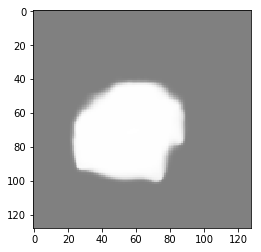

In [16]:
newshape = predicted_mask.swapaxes(1,3)
print('newshape shape ', newshape.shape)
grey = grey2rgb(newshape[3])
print('grey shape ', grey.shape)
plt.imshow(grey, alpha = 0.5)
plt.show()

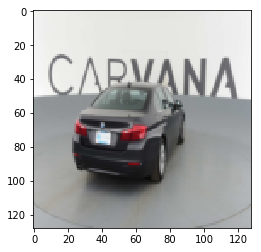

In [17]:
# the corresponding image is:
newshape = img[3].swapaxes(0,2)
plt.imshow(newshape)
plt.show()

# generates batches for test

In [18]:
# generator that we will use to read the data from the directory
def data_gen_test(test_dir, images, batch_size, dims):
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            for i in ix:
                # images
                original_img = Image.open(images[i])
                #original_img = cv2.imread(images[i]) # todo cv2 here
                resized_img = imresize(original_img, dims+[3]) #this looks like TensorFlow ordering 
                array_img = resized_img / 255   
                array_img = array_img.swapaxes(0,2)
                imgs.append(array_img)
                #imgs is a numpy array with dim: (batch size X 128 X 128 X 3)      
            imgs = np.array(imgs)
            yield imgs

test_gen = data_gen_test('test/', test, n_batch, dims) 

# -------------------------------------------

In [19]:
## Used to save time
import multiprocessing

import time
import gc
from multiprocessing import Pool

CPUs = multiprocessing.cpu_count()

## Mask properties
WIDTH_ORIG = 1918
HEIGHT_ORIG = 1280

## More Tuning
MASK_THRESHOLD = 0.6

## Submission data
df_test = pd.read_csv('sample_submission.csv')
print('sample_submission.csv shape:: ', df_test.shape)
print('sample_submission.csv columns:: ', df_test.columns.values.tolist())
ids_test = df_test['img'].map(lambda s: s.split('.')[0])
## will be used in making submission
names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))

sample_submission.csv shape::  (100064, 2)
sample_submission.csv columns::  ['img', 'rle_mask']


In [20]:
## https://www.kaggle.com/hackerpoet/even-faster-run-length-encoder
def run_length_encode(img):
    img = cv2.resize(img, (WIDTH_ORIG, HEIGHT_ORIG))
    flat_img = img.flatten()
    flat_img[0] = 0
    flat_img[-1] = 0
    flat_img = np.where(flat_img > 0.5, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix

    encoding = ''
    for idx in range(len(starts_ix)):
        encoding += '%d %d ' % (starts_ix[idx], lengths[idx])
    return encoding.strip()

In [21]:
rles = []

##  Split cz you can't keep all the images in memory at once
test_splits = 59  # Split test set (number of splits must be multiple of 59
ids_test_splits = np.split(ids_test, indices_or_sections=test_splits)
split_count = 0
batch_size = n_batch

# ---------------------------------

# todo az alabbi egyenlore lassu

In [26]:
# predict_generator(self, generator, steps, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)


# predict the test dataset
# todo: multiprocessing
# https://www.kaggle.com/rrqqmm/even-faster-submission
n_step = 100064 / n_batch
print('n_steps = '+ str(n_step))
result = model.predict_generator(generator=test_gen,steps = n_step,workers=1, use_multiprocessing=False, verbose = 1)
newshape = result.swapaxes(1,3)


# test plot
grey = grey2rgb(newshape[3])
print(result.shape)
print(newshape.shape)
print(grey.shape)

plt.imshow(grey)
plt.show()

n_steps = 3127.0
  76/3127 [..............................] - ETA: 5919s

KeyboardInterrupt: 

In [ ]:
# prediction to a list
res_list = []
for i in range(0,result.shape[0]):
    orig_img = imresize(result[i], [1280, 1918]+[1])
    res_list.append(orig_img.flatten())
print('list is done')

In [ ]:
# test name to a list
ids_test = test['img'].map(lambda s: s.split('.')[0])
## will be used in making submission
names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': res_list})
df.to_csv('submission2_1.csv.gz', index=False, compression='gzip')